# Introduction

Optyx provides tensor network evaluation for hybrid circuits over photonic and qubit modes.

The package is structured into three modules giving different *generators* for the nodes in the network.
- ZX diagrams: generated by the phased Z and X spiders and the hadamard box.
- ZW diagrams: generated by the split map W and its dagger, as well as Z spiders on the Fock space.
- LO circuits: generated by beam splitters, phase shifts, and other gates.

The `optyx.Diagram` class can store any (well-typed) composition of the above generators together with the `DualRail` encoding.

The `channel.Circuit` class provides the simulation of any composition as a completely positive maps. 
It gives further generators `Encode`, `Measure`, `Discard` and `CPhase`, allowing to simulate arbitrary circuits with measurements and classical control.

### Build a linear optical circuit

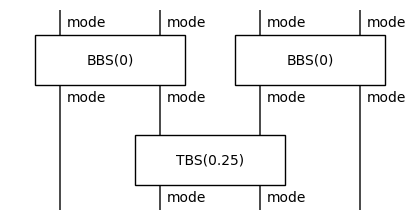

In [3]:
from optyx import lo

circuit = lo.BS @ lo.BS >> lo.Id(1) @ lo.TBS(0.25) @ lo.Id(1)
circuit.foliation().draw()

### Evaluate an amplitude of the circuit

In [27]:
from optyx import zw

state = zw.Create(1, 0, 0, 1)
effect = zw.Select(0, 1, 0, 1)

(state >> circuit >> effect).to_zw().to_tensor().eval()

Tensor[complex128]([0.+0.35355339j], dom=Dim(1), cod=Dim(1))

### Evaluate the output distribution with Perceval

In [85]:
(state >> circuit).to_path().prob_with_perceval()

Probabilities[complex]([0.  +0.j, 0.125+0.j, 0.125+0.j, 0.25 +0.j, 0.125+0.j, 0.  +0.j,
 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.  +0.j], dom=1, cod=10)

### Evaluate the output distribution with tensor networks

In [42]:
from optyx.channel import Channel, Measure, Discard, qmode

channel = Channel('circuit', circuit) >> Discard(qmode ** 2) @ Measure(qmode) @ Discard(qmode)

distribution =  Channel('product state', state) >> channel
distribution.double().to_zw().to_tensor(max_dim=3).eval().array.round(3)

array([0.625+0.j, 0.25 +0.j, 0.125+0.j])

### Build an entangled state in ZX

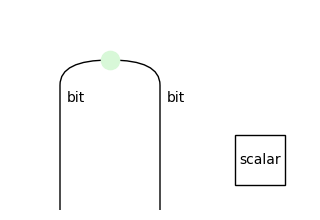

In [126]:
from optyx import zx, optyx
import numpy as np
from discopy.drawing import Equation

qubit_state = zx.Z(0, 2) @ zx.Scalar(1/np.sqrt(2))
qubit_state.draw()

### Evaluate a hybrid channel with qubits and qmodes.

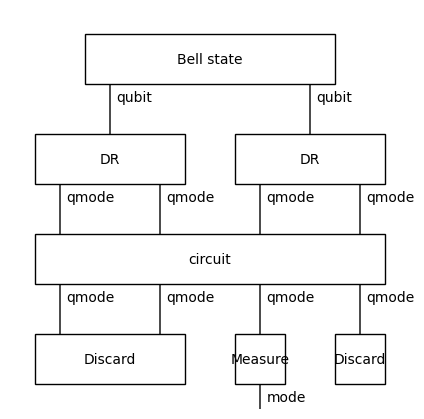

In [93]:
from optyx.channel import qubit

q_state = Channel('Bell state', qubit_state)
dual_rail = Channel('DR', optyx.DualRail())
hybrid_setup = q_state >> dual_rail @ dual_rail >> channel
hybrid_setup.foliation().draw()

In [94]:
hybrid_setup.double().to_zw().to_tensor(max_dim=3).eval().array.round(3)

array([0.75+0.j, 0.  +0.j, 0.25+0.j])

### Compute the same distribution with a lossy optical circuit

In [118]:
import numpy as np

eff = 0.98
kraus= zw.W(2) >> zw.Endo(np.sqrt(eff)) @ zw.Endo(np.sqrt(1-eff))
loss = Channel(name=f'loss({eff})', kraus=kraus, dom=qmode, cod=qmode, env=optyx.mode)
uniform_loss = loss.tensor(*[loss for _ in range(3)])
lossy_setup = q_state >> dual_rail @ dual_rail >> uniform_loss >> channel
lossy_setup.double().to_zw().to_tensor(max_dim=3).eval().array.round(7)

array([0.7501+0.j, 0.0098+0.j, 0.2401+0.j])

### Compute the distribution in the presence of a qubit error

In [125]:

p = 0.97
dephasing = Channel(name='Zerror', kraus=optyx.Spider(1, 2, optyx.bit), dom=qubit, cod=qubit, env=optyx.bit)
dephased_setup = q_state >> dephasing @ Circuit.id( >> dual_rail @ dual_rail >> channel
dephased_setup.double().to_zw().to_tensor(max_dim=3).eval().array.round(7)

array([0.625+0.j, 0.25 +0.j, 0.125+0.j])